In [33]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
import copy 


In [34]:
# Boundary conditions
def Apply_bc(K, F, elem_index):
    phi = 1.0
    bignumber = 10.0**30
    dof = connect[elem_index][0]
    value, bc_type = bc_dict[materials[elem_index]]
    if bc_type == "dirichlet":
        K[dof, dof] += bignumber*phi*phi
        F[dof] += bignumber*float(value)*phi


In [35]:
# Global index of local DOF:
def Gl_index(elem_index, local_dof):
    return connect[elem_index][local_dof]


In [36]:
def Contribute_el(K, M, F, elem_index):
    """Computes the contribution of elment in the global stiffness and mass matrices, and load vector.'\n'
    Arguments:'\n'
    K -- Global stiffness matrix which will be alterated to take account the contribution; '\n'
    M -- Global stiffness matrix;'\n' 
    F -- Global load vector;'\n'
    elem_index -- element index"""
    
    # Element stiffness matrix and element load vector
    h = L/n_el
    k_elem = E*A/h * np.array([[1.0, -1.0], [-1.0, 1.0]])
    m_elem = rho*A*h/2 * np.array([[1.0, 0.0], [0.0, 1.0]])
    f_elem = np.array([0.0, 0.0])
    # Contribution to K, M and F
    for i_loc in range(2):
        i_gl = Gl_index(elem_index, i_loc)
        F[i_gl] += f_elem[i_loc]
        for j_loc in range(2):
            j_gl = Gl_index(elem_index, j_loc)
            K[i_gl, j_gl] += k_elem[i_loc, j_loc]
            M[i_gl, j_gl] += m_elem[i_loc, j_loc]


In [37]:
# Global stiffness matrix and mass matrix
def GlobalSystem():
    n_dofs = max(list(itertools.chain.from_iterable(connect))) + 1
    K = np.zeros((n_dofs, n_dofs))
    F = np.zeros((n_dofs))
    M = np.zeros((n_dofs, n_dofs))
    # Assembly of elements
    n_el = len(connect)
    for i_el in range(n_el):
        mat_id = materials[i_el]
        if mat_id == 0:
            Contribute_el(K, M, F, i_el)
        elif mat_id == 2:
            Apply_bc(K, F, i_el)

    return K, M, F


In [38]:
# Newmark's method explicit
def Newmark_exp(K, M, C, u, v, acel, p_next, dt, gamma):

    # Degrees of freedom
    dofs = K.shape[0]
    
    up = np.zeros((dofs))
    vp = np.zeros((dofs))
    u_next = np.zeros((dofs))
    acel_next = np.zeros((dofs))
    v_next = np.zeros((dofs))

    u_next = u + dt*v + ((1.0/2.0)*dt**2)*acel
    # Predictor vector vp
    vp = v + (1 - gamma)*dt*acel

    # Solution of the linear problem:
    term1 = M + gamma*dt/2*C 
    Minv = np.linalg.inv(term1)
    f_int = Force_int(u_next)
    term2 = p_next - f_int - np.matmul(C, vp)
    acel_next = np.matmul(Minv, term2)
    

    for i_el in range(len(connect)):
        if materials[i_el] == 2:
            value, bc_type = bc_dict[materials[i_el]]
            if bc_type == "dirichlet":
                i_dof = Gl_index(i_el,0)
                u_next[i_dof] = value
                acel_next[i_dof] = 0.0
                v_next[i_dof] = 0.0
                
    # Correctors
    v_next = vp + gamma*dt*acel_next

    return u_next, v_next, acel_next


In [39]:
# Plot functions

# Plot data in nodes
def plot(x, y, labelx, labely, title):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str(title))
    plt.xlabel(str(labelx))
    plt.ylabel(str(labely))
    plt.plot(x, y)
    plt.show()

# Plot data in element


def plot_interior(x0, xf, n_elem, func, labelx, labely, title):
    h = float(xf-x0)/n_elem
    x = np.array([[x0+h*el, x0+h*(el+1)] for el in range(n_elem)])
    x = x.flatten()
    y = np.array([[func[el], func[el]] for el in range(n_elem)])
    y = y.flatten()
    plot(x, y, labelx, labely, title)

# Plot data in time


def plot_time(n_steps, func, labelx, labely, title):
    x = np.linspace(0, n_steps, n_steps)
    y = func
    plot(x, y, labelx, labely, title)

# Plot energy


def plot_energy(n_steps, E_kin, E_pot, labelx, labely, title):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str(title))
    plt.xlabel(str(labelx))
    plt.ylabel(str(labely))
    x = np.linspace(0, n_steps, n_steps)
    plt.plot(x, E_kin, label='E_kin')
    plt.plot(x, E_pot, label='E_pot')
    plt.legend()
    plt.show()


def plot_energytotal(n_steps, E_kin, E_pot, E_tot, labelx, labely, title):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')
    plt.title(str(title))
    plt.xlabel(str(labelx))
    plt.ylabel(str(labely))
    x = np.linspace(0, n_steps, n_steps)
    plt.plot(x, E_kin, label='E_kin')
    plt.plot(x, E_pot, label='E_pot')
    plt.plot(x, E_tot, label='E_tot')
    plt.legend()
    plt.show()


In [40]:
# Energy balance
def energy(K, M, u, v):
    # Kinetic energy
    E_kin = 1.0/2.0*np.dot(np.matmul(M, v), v)
    # Potential energy
    E_pot = 1.0/2.0*np.dot(np.matmul(K, u), u)
    # Total
    E_tot = E_kin + E_pot
    return E_kin, E_pot, E_tot


In [41]:
def cohesive_law(jump_u):
    stress = stress_c * (1.0 - jump_u/delta_c)
    if stress < 0.0:
        stress = 0.0
    return stress


In [42]:
def Insert_interface(el_left, el_right, u, v, acel):
    dof_broken = connect[el_left][1]
    # Update the connect list
    n_dofs = u.shape[0]
    connect[el_right][0] = n_dofs
    dof_right = n_dofs
    dof_left = connect[el_left][1]
    connect.append([dof_left, dof_right])
    # Update materials type
    materials.append(1)
    # Update node ID
    node_id.append(node_id[el_left][1])
    # Update u, v and acel arrays
    u = np.append(u, u[dof_broken])
    v = np.append(v, v[dof_broken])
    acel = np.append(acel, acel[dof_broken])

    return u, v, acel


In [43]:
def Force_int(u):
    """ Returns the internal force vector (ku + flambda)

    Arguments:\n
    u -- displacemnt vector
    """
    
    # Element stiffness matrix
    h = L/n_el
    k_elem = E*A/h * np.array([[1.0, -1.0], [-1.0, 1.0]])
    n_dofs = u.shape[0]
    fint = np.zeros(n_dofs)
    for el in range(n_el):
        u_loc = np.array([u[Gl_index(el, 0)], u[Gl_index(el, 1)]])
        fint_loc = np.matmul(k_elem, u_loc)

        for i_loc in range(2):
            i_gl = Gl_index(el, i_loc)
            fint[i_gl] += fint_loc[i_loc]

    fint += Force_interface(u)

    return fint


In [44]:
def Force_interface(u):
    """ Returns the force of interfaces (flambda)

    Arguments:\n
    u -- displacemnt vector
    """
    n_dofs = u.shape[0]
    flambda = np.zeros(n_dofs)
    for el in range(els_step):
        if materials[el] == 1:
            jump_u = u[connect[el][1]] - u[connect[el][0]]
            flambda[connect[el][0]] = cohesive_law(jump_u) * A
            flambda[connect[el][1]] = -flambda[connect[el][0]]

    return flambda


In [45]:
def PostProcess(u):
    """ Returns the strain, stress vectors of the linear elements, and the average stress vector between two consecutives line elements

    Arguments:\n
    u -- displacemnt vector
    """

    strain = np.zeros(n_el)
    stress = np.zeros(n_el)

    for el in range(n_el):
        # Strain[u,L] returns the strain value at each element 'el' for the step 'n'
        strain[el] = (u[connect[el][1]] - u[connect[el][0]]) / h
        # Stress[strain] retuns the stress value at each element 'el' for the step 'n'
        stress[el] = E * strain[el]

    average = lambda el: (stress[el] + stress[el+1])/2.0 if connect[el][1] == connect[el+1][0] else 0       
       
    average_stress = [average(el) for el in range(n_el-1)]

    return strain, stress, average_stress


In [46]:
# Mesh
L = 0.2  # (m)
n_el = 5
h = L/n_el

# Material id convention: 0(line elemnt)/1(interface element)/2(BC left node)/3(BC right node)
materials = [0] * n_el
materials.append(2)
print(materials)
# node_id[elem_index][local_node], returns the global node id
node_id = []
for i in range(n_el):
    node_id.append([i, i+1])
# Node BC
node_id.append([0])

# Connect[el][j] returns the global index of local dof 'j' of the element 'el'
connect = copy.deepcopy(node_id) 

# BC
bc_dict = dict([(2, (0, "dirichlet"))])
n_dofs = max(list(itertools.chain.from_iterable(connect))) + 1


[0, 0, 0, 0, 0, 2]


In [47]:
# Input parameters

# Material parameters
E = 275.0*10**3  # (Pa)

A = 0.001  # (unit area)
Gc = 100.0  # (N/m)
stress_c = 100.0*10**1  # (Pa)
rho = 75.0  # (kg/m3)
delta_c = (2.0*Gc)/stress_c

# Time steps
n_steps = 5

# Applied strain rate
strain_rate = 10.0**2  # (s-1)

# Initial displacement
u0 = np.zeros((n_dofs))
# Initial velocity (v0): velocity profile (vel) is a function v(x)
vel = strain_rate*L
n_points = n_dofs
l = np.linspace(0, L, n_points)
v0 = np.array([vel/L*x for x in l])
v0 = np.round(v0, 8)
print(v0)

# Initial acceleration (acel0)
acel0 = np.zeros((n_dofs))
# Load (p)
p = np.zeros((n_steps+1, n_dofs))

# Time integration
dt = 10**-4  # (s)
gamma = 0.5
beta = 0.0
C = np.zeros((n_dofs, n_dofs))

dt_crit = h/((E/rho)**0.5)
print(dt_crit)


[ 0.  4.  8. 12. 16. 20.]
0.0006605782590758165


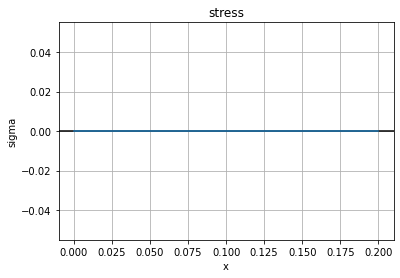

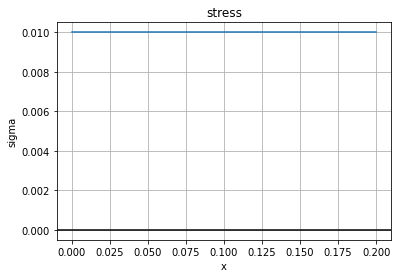

[[0, 1], [6, 2], [2, 3], [3, 4], [4, 5], [0], [1, 6]]
[[0, 1], [6, 2], [7, 3], [3, 4], [4, 5], [0], [1, 6], [2, 7]]
[[0, 1], [6, 2], [7, 3], [8, 4], [4, 5], [0], [1, 6], [2, 7], [3, 8]]
[[0, 1], [6, 2], [7, 3], [8, 4], [9, 5], [0], [1, 6], [2, 7], [3, 8], [4, 9]]


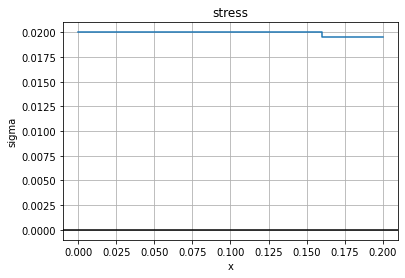

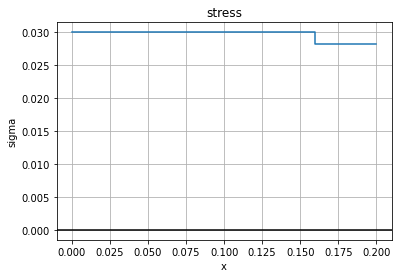

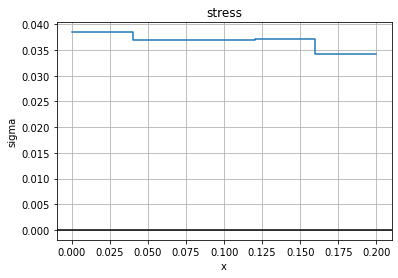

In [48]:
# Global algorithm

u = u0
v = v0
acel = acel0
E_kin = np.zeros((n_steps))
E_pot = np.zeros((n_steps))
E_tot = np.zeros((n_steps))
els_step = n_el

for n in range(n_steps):

    strain, stress, average_stress = PostProcess(u)
    # Get K, M and F
    K, M, F = GlobalSystem()
    C = np.resize(C,K.shape)
    # print(u)
    plot_interior(0, L, n_el, strain, "x", "sigma", "stress")
    # u,v,acel returns a vector for u,v and acel at every dof at the n step
    u, v, acel = Newmark_exp(K, M, C, u, v, acel, F, dt, gamma)
    E_kin[n], E_pot[n], E_tot[n] = energy(K, M, u, v)

    # Check limit stress
    for el in range(n_el-1):
        if average_stress[el] > stress_c:
            # Fracture happens: creat new interface element
            u, v, acel = Insert_interface(el, el+1, u, v, acel)
            els_step = els_step + 1
            print(connect)
            
# # Plots of energy
# plot_energy(n_steps,E_kin,E_pot,"time_step","Energy","Energy balance")

# # Variation of energy
# vEkin = np.zeros((n_steps))
# vEpot = np.zeros((n_steps))
# vEtot = np.zeros((n_steps))

# for n in range(n_steps-1):
#     vEkin[n+1] = E_kin[n+1] - E_kin[n]
#     vEpot[n+1] = E_pot[n+1] - E_pot[n]
#     vEtot[n+1] = vEkin[n+1] + vEpot[n+1]
# plot_energytotal(n_steps,vEkin,vEpot,vEtot,"time_step","Energy","Energy balance")
